Add necessary imports

In [ ]:
import numpy as np
import os
import json
import tensorflow as tf
import random
!pip install mediapipe
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 243 kB/s 
Mounted at /content/drive


Configure MediaPipe FaceMesh

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

Grab data from training model

In [ ]:
json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json/'
all_json_files = os.listdir(json_path)

json_data = {}
for filename in all_json_files:
  with open('/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json/'+filename, 'r') as file:
    s_data = json.load(file)
    json_data = {**json_data, **s_data}

In [ ]:
left_eye_point = set(sum(mp_face_mesh.FACEMESH_LEFT_EYE, ()))
right_eye_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_EYE, ()))
left_iris_point = set(sum(mp_face_mesh.FACEMESH_LEFT_IRIS, ()))
right_iris_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_IRIS, ()))

keypoints = left_eye_point.union(right_eye_point).union(left_iris_point).union(right_iris_point)

keypoints = sorted(list(keypoints))

Set training data, training labels, validation data, and validation labels

In [ ]:
train_x = []
train_y = []

val_x = []
val_y = []

for subject in json_data:
  subject_data = json_data[subject];
  train_vids = random.sample(range(0,len(subject_data)), 100)
  for idx, video in enumerate(subject_data):
    for all_features in video['features']:
    #all_features = video['features'][0] # 0 picks the first frame per video. change this eventually?
      if idx in train_vids:
        train_x.append([all_features[i] for i in keypoints])
        train_y.append([int(video['x'])/100, int(video['y'])/100])
      else:
        val_x.append([all_features[i] for i in keypoints])
        val_y.append([int(video['x'])/100, int(video['y'])/100])

Manipulate amount of data passed into the model for training

In [ ]:
print((train_x)[len(train_x) - 1])
print((train_x[len(train_x) - int((len(train_x)) / 2):len(train_x)])[-1])

[[0.5126137733459473, 0.40542715787887573, 0.018997950479388237], [0.5073082447052002, 0.4013996422290802, 0.023804036900401115], [0.5715897679328918, 0.40161389112472534, 0.01481738779693842], [0.5257376432418823, 0.40939581394195557, 0.01069391518831253], [0.5372234582901001, 0.40973612666130066, 0.007741346023976803], [0.5487976670265198, 0.4079928398132324, 0.008030279539525509], [0.5597202181816101, 0.4051024317741394, 0.010781769640743732], [0.5673558712005615, 0.40341609716415405, 0.014346753247082233], [0.558515727519989, 0.3926830291748047, 0.00927429273724556], [0.5462576746940613, 0.38987159729003906, 0.006591478828340769], [0.5345450639724731, 0.38924872875213623, 0.006624232511967421], [0.5227996110916138, 0.39157819747924805, 0.009360800497233868], [0.5152862071990967, 0.3953254222869873, 0.013352828100323677], [0.5180455446243286, 0.40758633613586426, 0.015048015862703323], [0.56743985414505, 0.39741870760917664, 0.012613793835043907], [0.510869026184082, 0.3985104858875

In [ ]:
vae_input = train_x
#vae_input = train_x[1:len(train_x)]

print(np.shape(vae_input))
vae_input_length = (len(vae_input))

counter = 0
random_matrix = np.random.rand(40, 3)

while(counter < vae_input_length):
    altered_data = []
    i = 0
    while(i < (len(vae_input[counter]))):
        x = (vae_input[counter][i][0] + random_matrix[i][0]) / 2
        y = (vae_input[counter][i][1] + random_matrix[i][1]) / 2
        z = vae_input[counter][i][2]
        altered_data.append([x, y, z])
        i += 1
    #print(np.shape(altered_data))
    vae_input.append(altered_data)
    counter += 1

print(np.shape(vae_input))



Function for translating facial landmarks

In [ ]:
def translate(arr, x_translation, y_translation):
    translated_arr = []
    for element in arr:
        x = element[0] + x_translation
        y = element[1] + y_translation
        translated_arr.append([x, y, element[2]])
    return translated_arr

In [ ]:
length = len(train_x)
i = 0
while(i < length):
    train_x.append(translate(train_x[i], 0.002, 0.002))
    i += 1
print(np.shape(train_x))

(123084, 40, 3)


Function for rotating facial landmarks

In [ ]:
def rotate(arr, angle):
    i = 0
    rotated_arr = []
    rotation = [[np.cos(angle * (np.pi / 180)), np.sin(angle * (np.pi / 180)) * -1],
     [np.sin(angle * (np.pi / 180)), np.cos(angle * (np.pi / 180))]]
    for element in arr:
        degree_rotation = (np.matmul(rotation, [element[0], element[1]]))
        rotated_arr_with_z = np.append(degree_rotation, (element[2]))
        rotated_arr.append(rotated_arr_with_z)
        print(rotated_arr)
        i += 1
    return rotated_arr

In [ ]:
def no_matrix_rotate(arr, angle):
    i = 0
    rotated_arr = []
    for element in arr:
        x = element[0] * np.cos(angle * (np.pi / 180)) - element[1] * np.sin(angle * (np.pi / 180))
        y = element[0] * np.sin(angle * (np.pi / 180)) + element[1] * np.cos(angle * (np.pi / 180))
        z = element[2]
        rotated_arr.append([x, y, z])
        #print(rotated_arr)
        i += 1
    return rotated_arr


In [ ]:
no_matrix_rotate([[3, 5, 6]], 50)

[[-1.9018593865352718, 5.512071377789631, 6]]

In [ ]:
length = len(train_x)
i = 0
while(i < length):
    train_x.append(no_matrix_rotate(train_x[i], 45))
    i += 1
print(np.shape(train_x))

(61608, 40, 3)


VAE for compressing head/eye position

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a mesh."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        kl_loss = 1/300 * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name='kl_loss')

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

vae_encoder_inputs = tf.keras.Input(shape=(40,3), name="vae_encoder_input")
vae_encoder_flatten = tf.keras.layers.Flatten(name="vae_flatten")(vae_encoder_inputs)
vae_encoder_dense_1 = tf.keras.layers.Dense(units=200, activation="relu", name="vae_dense_1")(vae_encoder_flatten)
vae_encoder_dense_2 = tf.keras.layers.Dense(units=50, activation="relu", name="vae_dense_2")(vae_encoder_dense_1)
z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(vae_encoder_dense_2)
z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(vae_encoder_dense_2)
vae_encoder = tf.keras.Model(inputs=vae_encoder_inputs, outputs=[z_mean, z_log_var])

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 40, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 120)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          24200       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 50)           10050       ['vae_dense_1[0][0]']            
                                                                                              

In [ ]:
z = Sampling(name="vae_sampling")([z_mean, z_log_var])

vae_decoder_dense_1 = tf.keras.layers.Dense(50, activation="relu", name="vae_decoder_dense_1")(z)
vae_decoder_dense_2 = tf.keras.layers.Dense(200, activation="relu", name="vae_decoder_dense_2")(vae_decoder_dense_1)
vae_decoder_dense_3 = tf.keras.layers.Dense(120, activation="sigmoid", name="vae_decoder_dense_3")(vae_decoder_dense_2)
vae_decoder_outputs = tf.keras.layers.Reshape((40,3), name="vae_decoder_reshape")(vae_decoder_dense_3)

vae_decoder = tf.keras.Model(inputs=z, outputs=vae_decoder_outputs)

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 vae_decoder_dense_1 (Dense)  (None, 50)               150       
                                                                 
 vae_decoder_dense_2 (Dense)  (None, 200)              10200     
                                                                 
 vae_decoder_dense_3 (Dense)  (None, 120)              24120     
                                                                 
 vae_decoder_reshape (Reshap  (None, 40, 3)            0         
 e)                                                              
                                                                 
Total params: 34,470
Trainable params: 34,470
Non-trainable params: 0
_______________________________________________________

In [ ]:
vae = tf.keras.Model(inputs=vae_encoder_inputs, outputs=vae_decoder_outputs, name="VAE")

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 40, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 120)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          24200       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 50)           10050       ['vae_dense_1[0][0]']            
                                                                                                

In [ ]:
vae.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

In [ ]:
vae.fit(x=train_x, y=train_x, epochs=20)

Epoch 1/20
1926/1926 [==============================] - 11s 5ms/step - loss: 0.0080 - mean_squared_error: 0.0049 - kl_loss: 0.0031
Epoch 2/20
1926/1926 [==============================] - 9s 5ms/step - loss: 0.0056 - mean_squared_error: 0.0029 - kl_loss: 0.0027
Epoch 3/20
1926/1926 [==============================] - 9s 5ms/step - loss: 0.0054 - mean_squared_error: 0.0027 - kl_loss: 0.0028
Epoch 4/20
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0054 - mean_squared_error: 0.0025 - kl_loss: 0.0028
Epoch 5/20
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0025 - kl_loss: 0.0028
Epoch 6/20
1926/1926 [==============================] - 9s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0024 - kl_loss: 0.0029
Epoch 7/20
1926/1926 [==============================] - 9s 5ms/step - loss: 0.0052 - mean_squared_error: 0.0023 - kl_loss: 0.0029
Epoch 8/20
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0052 - m

In [ ]:
validation_metrics = vae.evaluate(val_x, val_x)
a = validation_metrics[0]
b = validation_metrics[1]
c = validation_metrics[2]
print(a)
print(b)
print(c)

266/266 [==============================] - 1s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0018 - kl_loss: 0.0030
0.004781802650541067
0.0018207266693934798
0.002961032558232546


In [ ]:
test_arr = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
for i in test_arr:
    print(i[0])

vae_input2 = vae_input[(len(vae_input) - 1):len(vae_input)]
print(len(vae_input))
print(np.shape(vae_input[30829:len(vae_input)]))
print((vae_input)[1:2])

1
1
1
61660


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(30831, 40, 3)
[[[0.5753636360168457, 0.4491119384765625, 0.013888662680983543], [0.569682240486145, 0.4456426501274109, 0.01768714189529419], [0.6326629519462585, 0.4467892050743103, 0.013380974531173706], [0.589121401309967, 0.45239484310150146, 0.00746564008295536], [0.6007358431816101, 0.4525061845779419, 0.0055082435719668865], [0.6120511293411255, 0.4510055184364319, 0.0062385499477386475], [0.6227701902389526, 0.44872283935546875, 0.009102528914809227], [0.629584789276123, 0.44764503836631775, 0.012601029127836227], [0.6201658844947815, 0.436300128698349, 0.008402155712246895], [0.6079302430152893, 0.4327719807624817, 0.005225765984505415], [0.5959428548812866, 0.43281689286231995, 0.004605198744684458], [0.5842740535736084, 0.4360642433166504, 0.00623345235362649], [0.5770697593688965, 0.44025129079818726, 0.009256523102521896], [0.5812187790870667, 0.4510772228240967, 0.010670437477529049], [0.6287278532981873, 0.4424865245819092, 0.011454778723418713], [0.5728598237037659, 0.

In [ ]:
x = 16
units = []
validation_metrics = []
loss = []
mse = []
kl_loss = []

while (x >= 1):
    vae_input2 = vae_input[len(vae_input) - int((len(vae_input)) / x):len(vae_input)]
    vae.fit(x=vae_input2, y=vae_input2, epochs=20)

    units.append(np.shape(vae_input2)[0])
    validation_metrics.append(vae.evaluate(val_x, val_x))
    x = x / 2

for i in validation_metrics:
    loss.append(i[0])
    mse.append(i[1])
    kl_loss.append(i[2])

plt.plot(units, loss, label='loss')
plt.plot(units, mse, label='mse')
plt.plot(units, kl_loss, label='kl_loss')
plt.legend()



NameError: ignored

In [ ]:
x = 2
vae_input = train_x[len(train_x) - int((len(train_x)) / x):len(train_x)]
vae.fit(x=vae_input, y=vae_input, epochs=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1348, in fit
    steps_per_execution=self._steps_per_execution)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/data_adapter.py", line 1399, in get_data_handler
    return DataHandler(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/data_adapter.py", line 1161, in __init__
    model=model)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/data_adapter.py", line 236, in __init__
    x, y, sample_weights = _process_tensorlike((x, y, sample_weights))
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/data_adapter.py", line 1043, in _process_tensorlike
    inputs = tf.nest.map_structure(_convert_single_tensor, inputs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/nest.py", line 914, in map_structure
    structure[0], [func(*x) for x in entries],
  File "/usr/local/lib/python3.7/dist-packages/tens

TypeError: ignored

Epoch 1/20
121/121 [==============================] - 1s 5ms/step - loss: 0.0028 - mean_squared_error: 8.0263e-04 - kl_loss: 0.0020
Epoch 2/20
121/121 [==============================] - 1s 5ms/step - loss: 0.0020 - mean_squared_error: 7.6022e-04 - kl_loss: 0.0013
Epoch 3/20
121/121 [==============================] - 1s 5ms/step - loss: 0.0012 - mean_squared_error: 6.7941e-04 - kl_loss: 4.8103e-04
Epoch 4/20
121/121 [==============================] - 1s 5ms/step - loss: 7.6769e-04 - mean_squared_error: 6.8500e-04 - kl_loss: 8.2480e-05
Epoch 5/20
121/121 [==============================] - 1s 5ms/step - loss: 7.0329e-04 - mean_squared_error: 6.6370e-04 - kl_loss: 3.9683e-05
Epoch 6/20
121/121 [==============================] - 1s 5ms/step - loss: 6.9829e-04 - mean_squared_error: 6.7738e-04 - kl_loss: 2.0861e-05
Epoch 7/20
121/121 [==============================] - 1s 5ms/step - loss: 6.9278e-04 - mean_squared_error: 6.8021e-04 - kl_loss: 1.2561e-05
Epoch 8/20
121/121 [====================

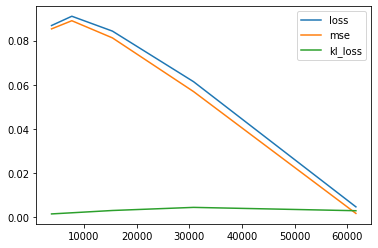

In [ ]:
x = 16
units = []
validation_metrics = []
loss = []
mse = []
kl_loss = []

while (x >= 1):
    vae_input = train_x[len(train_x) - int((len(train_x)) / x):len(train_x)]
    vae.fit(x=vae_input, y=vae_input, epochs=20)

    units.append(np.shape(vae_input)[0])
    validation_metrics.append(vae.evaluate(val_x, val_x))
    x = x / 2

for i in validation_metrics:
    loss.append(i[0])
    mse.append(i[1])
    kl_loss.append(i[2])

plt.plot(units, loss, label='loss')
plt.plot(units, mse, label='mse')
plt.plot(units, kl_loss, label='kl_loss')
plt.legend()

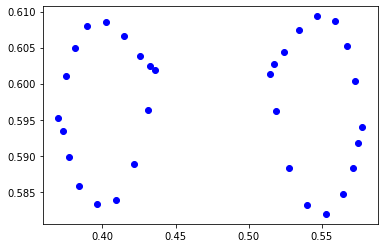

In [ ]:
a = vae_decoder.predict([[1,-1]])
b = a[0]
plt.plot(b[0:32,0],b[0:32,1], 'bo')

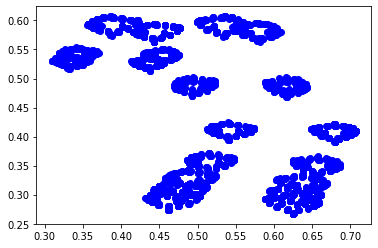

In [ ]:
x = np.linspace(-2,2,10)
y = np.linspace(-2,2,10)
fig = plt.figure()

for x_val in x:
  for y_val in y:
    points = vae_decoder.predict([[x_val,y_val]])[0]
    x_coords = points[:,0]
    y_coords = points[:,1]
    
    plt.plot(x_coords, y_coords, 'bo')